In [1]:
import concurrent
import numpy as np
import numba as nb
import dask.array as da
import time
import matplotlib.pyplot as plt
from math import isnan, inf

In [2]:
def np_min_max(arr):
    return np.nanmin(arr), np.nanmax(arr)

def test_tpe(arr):
    thread_results = list()
    with concurrent.futures.ThreadPoolExecutor() as executor: 
         for result in executor.map(np_min_max, arr):
                thread_results.append(result)
    return np_min_max(thread_results)

def dask_min_max(arr):
    np.nanmin(arr).compute().item(), np.nanmax(arr).compute().item()

In [3]:
@nb.njit(fastmath=True, cache=True)
def _minmax_nan(x):
    maximum = -inf
    minimum = inf
    for i in x:
        if not isnan(i):
            if i > maximum:
                maximum = i
            if i < minimum:
                minimum = i
    return minimum, maximum

@nb.njit(parallel=True, cache=True)
def _minmax_chunks_nan(x, chunk_ranges):
    n_chunks = len(chunk_ranges)
    max_results = [-inf]*n_chunks
    min_results = [inf]*n_chunks
    for i in nb.prange(n_chunks):
        start = chunk_ranges[i, 0]
        end = chunk_ranges[i, 1]
        chunk_minimum, chunk_maximum = _minmax_nan(x[start : end])
        min_results[i] = chunk_minimum
        max_results[i] = chunk_maximum
            
    return min(min_results), max(max_results)

def even_chunk_sizes(dividend, divisor):
    quotient, remainder = divmod(dividend, divisor)
    cells = [quotient for _ in range(divisor)]
    for i in range(remainder):
        cells[i] += 1
    return cells

def even_chunk_ranges(dividend, divisor):
    sizes = even_chunk_sizes(dividend, divisor)
    ranges = []
    start = 0
    for s in sizes:
        end = start + s
        ranges.append((start, end))
        start = end
    return ranges

def nanminmax_parallel(x, n_chunks):
    chunk_ranges = np.array([
        [start, end]
        for start, end
        in even_chunk_ranges(len(x), n_chunks)
    ], dtype=np.int64)
    return _minmax_chunks_nan(x, chunk_ranges)

In [4]:
def time_multithreaded(arr, reps):
    start_setup = time.perf_counter()
    chunked_flat_np_arr = np.array_split(arr, 16)
    setup_time = time.perf_counter() - start_setup
    
    timings = list()
    for _ in range(reps):   
        t_0 = time.perf_counter()        
        test_tpe(chunked_flat_np_arr)
        t_e = time.perf_counter() - t_0
        timings.append(t_e)
    timings = np.array(timings)
    return {"time_avg": np.mean(timings)*1000, "timings": timings*1000, "setup_time": setup_time*1000}  


def time_plain_np(arr, reps):
    setup_time = 0
    
    timings = list()
    for _ in range(reps):   
        t_0 = time.perf_counter()        
        np_min_max(arr)
        t_e = time.perf_counter() - t_0 
        timings.append(t_e)
    timings = np.array(timings)
    return {"time_avg": np.mean(timings)*1000, "timings": timings*1000, "setup_time": setup_time*1000}  


def time_dask(arr, reps):
    start_setup = time.perf_counter()
    dask_arr = da.from_array(arr)
    setup_time = time.perf_counter() - start_setup
    
    timings = list()
    for _ in range(reps):   
        t_0 = time.perf_counter()        
        dask_min_max(dask_arr)
        t_e = time.perf_counter() - t_0
        timings.append(t_e)
    timings = np.array(timings)
    return {"time_avg": np.mean(timings)*1000, "timings": timings*1000, "setup_time": setup_time*1000}  

def time_jit_parallelized(arr, reps, n_chunks):
    setup_time = 0
    
    timings = list()
    for _ in range(reps):   
        t_0 = time.perf_counter()        
        nanminmax_parallel(arr, n_chunks)
        t_e = time.perf_counter() - t_0
        timings.append(t_e)
    timings = np.array(timings)
    return {"time_avg": np.mean(timings)*1000, "timings": timings*1000, "setup_time": setup_time*1000}  

In [5]:
def time_all(reps=2):
    timings = dict(reps=reps)
    for size in ARR_SIZES:
        timings[size] = dict()
        size_timing = timings[size]
        arr = np.random.rand(size).ravel()

        size_timing["plain"] = time_plain_np(arr, reps)
        size_timing["multithreaded"] = time_multithreaded(arr, reps)
        size_timing["dask"] = time_dask(arr, reps)
        size_timing["jit_parallel"] = time_jit_parallelized(arr, reps, 16)
    return timings

def get_timing_avg(timing_dict, method: str):
    timings = list()
    for size in ARR_SIZES:
        t = timing_dict[size][method]["time_avg"]
        timings.append(t)
    return np.array(timings)

def get_all_timings(timing_dict, method: str):
    timings = list()
    for size in ARR_SIZES:
        t = timing_dict[size][method]["timings"]
        timings.append(t)
    return np.array(timings)
    

In [6]:
ARR_SIZES = [10000, 100000, 1000000, 5000000, 25000000, 100000000, 250000000, 500000000, 1000000000]

In [7]:
REPS = 7

In [8]:
pre = time_jit_parallelized(np.array([]), 1, 1)  # compile jit before benchmark
setup_jit = pre["timings"][0]
print(f"JIT took {setup_jit} ms to compile.")
timing_results = time_all(REPS)

JIT took 160.94349999999835 ms to compile.


In [9]:
def show_benchmark(ylog=False):
    fig = plt.figure()
    x = ARR_SIZES
    
    y_plain = get_timing_avg(timing_results, "plain")
    plain_std = np.std(get_all_timings(timing_results, "plain"), axis=1)    
    plt.fill_between(x, y_plain, y_plain+plain_std, color='blue', alpha=0.1)
    plt.plot(x, y_plain, '--', color='blue', label='plain numpy')
    plt.fill_between(x, y_plain, y_plain-plain_std, color='blue', alpha=0.1)

    
    y_dask = get_timing_avg(timing_results, "dask")
    dask_std = np.std(get_all_timings(timing_results, "dask"), axis=1)    
    plt.fill_between(x, y_dask, y_dask+dask_std, color='orange', alpha=0.1)
    plt.plot(x, y_dask, '--', color='orange', label='dask')
    plt.fill_between(x, y_dask, y_dask-dask_std, color='orange', alpha=0.1)

    
    y_multithreaded = get_timing_avg(timing_results, "multithreaded")
    multithreaded_std = np.std(get_all_timings(timing_results, "multithreaded"), axis=1)    
    plt.fill_between(x, y_multithreaded, y_multithreaded+multithreaded_std, color='purple', alpha=0.1)
    plt.plot(x, y_multithreaded, '--', color='purple', label='multithreaded')
    plt.fill_between(x, y_multithreaded, y_multithreaded-multithreaded_std, color='purple', alpha=0.1)

    
    y_jit = get_timing_avg(timing_results, "jit_parallel")
    jit_std = np.std(get_all_timings(timing_results, "jit_parallel"), axis=1)    
    plt.fill_between(x, y_jit, y_jit+jit_std, color='black', alpha=0.1)
    plt.plot(x, y_jit, '--', color='black', label='jit_parallel')
    plt.fill_between(x, y_jit, y_jit-jit_std, color='black', alpha=0.1)

    plt.grid(axis='x', color='0.95')
    plt.xscale('log')
    if ylog:
        plt.yscale('log')
    plt.xlabel('Array size', fontsize=18)
    plt.ylabel('Time taken (ms)', fontsize=16)
    plt.legend(title='Calculation method:')
    plt.title(f'AVG of {REPS} repetitions using an i7-3770 @ 4.3GHz', fontsize=10)
    plt.suptitle('Benchmarking nanmin&nanmax calculation', fontsize=15)
    #plt.set_title('axes title')
    plt.show()

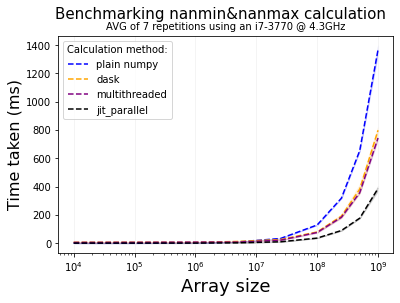

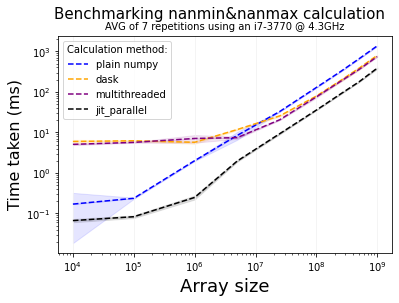

In [10]:
show_benchmark()
show_benchmark(ylog=True)

In [ ]:
get_all_timings(timing_results, "jit_parallel")

In [ ]:
#arr = np.random.rand(1000000000)

In [ ]:
#%timeit minmax_chunks_nan(arr, 4)  # (c) Saltrock

In [ ]:
#%timeit np_min_max(arr)  #  np.min+np.max

In [ ]:
#%timeit nb_min_max(arr) #  deleting nans then np.min+np.max with JIT

In [ ]:
#chunked_flat_np_arr = np.split(arr, 16) #  Multithreading
#%timeit test_tpe(chunked_flat_np_arr)

In [ ]:
#dask_arr = da.from_array(arr)  # Multiprocessing
#%timeit dask_min_max(dask_arr)

In [ ]:
#for size in range(ARR_SIZES
#nanminmax_parallel(arr, 2)):
#arr = np.arange(1000)
#time_jit_parallelized(arr, 1, 16)